<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N008 中心軸の推定

左右の輪郭から仮の中心軸をだしてみる。

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,Abs,re,im
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

# 左右のベジエ曲線の平均線

N006を済ませてあるなら、res フォルダに、９つの個体の左右の近似ベジエ曲線が保存されているはずなので、それを使って平均曲線を求め、表示してみよう。

In [2]:
# 予め求めてある左右分割のベジエ近似式を読み込む
fLlist = rd.loadPkl("fLlist.pkl",labhome+"/res") # 左側の近似曲線のリスト
fRlist = rd.loadPkl("fRlist.pkl",labhome+"/res") # 右側の近似曲線のリスト
imgs = rd.collectimages(NSilF)  # シルエット画像のリスト

def showAverage(num,n_samples=128):
    fl = fLlist[num]
    fr = fRlist[num]
    fc = (fl+fr)/2
    ps = np.linspace(0,1,n_samples)
    Lpoints = np.array([[int(float(fl[0].subs('t',s))),int(float(fl[1].subs('t',s)))] for s in ps])
    Rpoints = np.array([[int(float(fr[0].subs('t',s))),int(float(fr[1].subs('t',s)))] for s in ps])
    Cpoints = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in ps])
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.plot(Lpoints[:,0],Lpoints[:,1])
    plt.plot(Rpoints[:,0],Rpoints[:,1])
    plt.plot(Cpoints[:,0],Cpoints[:,1])

def showAverageAll():
    plt.figure(figsize=(10,10),dpi=75)
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)
            showAverage(3*i+j)

Wall time: 3.71 s


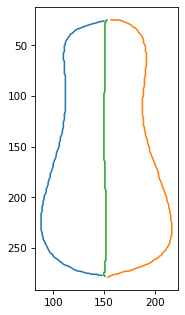

In [3]:
%%time
plt.figure(figsize=(5,5),dpi=75)
showAverage(0)

Wall time: 3.24 s


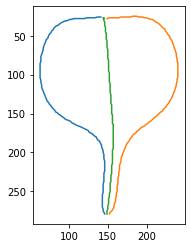

In [4]:
%%time
showAverage(1)

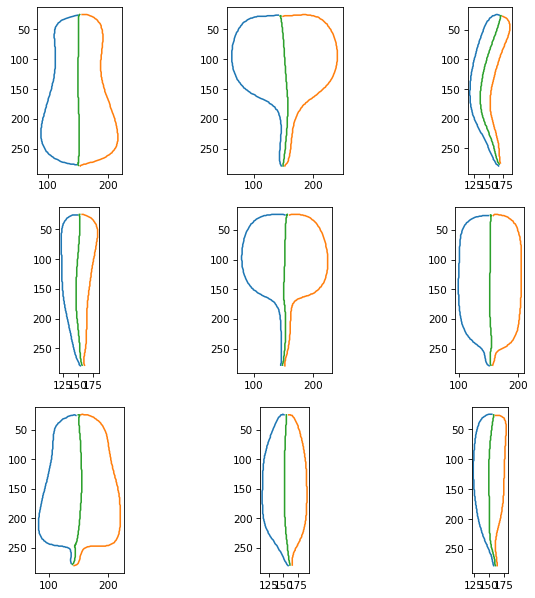

In [5]:
showAverageAll()

この９つの例に関して言えば、中心線として妥当見える。

これは左右分割が比較的成功しているからであり、上下の分割点が少しでもずれていたらこうはいかない。

また、太さの変化が激しい箇所、末端部の急激に細くなる部分は単純平均線は形状が不自然になることが多い。

例えば、左下の個体や中央右の個体でそれが顕著である。

N次ベジエ曲線の平均はやはり同じ次数の曲線となる。そもそも中心線は輪郭ほど複雑ではないはずなので、もっと次数は低くあるべきである。

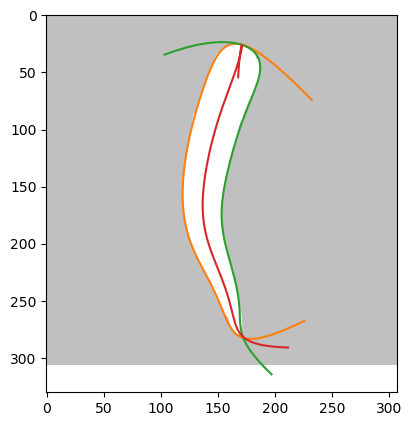

In [6]:
num = 2
img = imgs[num]
fl = fLlist[num]
fr = fRlist[num]
fc = (fl+fr)/2
rd.drawBez(img,stt=-0.1,end=1.1,bezL=fl,bezR=fr,bezC=fc,figsize=(5,5),dpi=100,ct=list("123"))

ベジエ曲線は通常パラメータ区間 [0,1] しか用いないが、あえて少し前後に延長して[-0.1,1,1]の範囲を描画してみたのが上の図である。

曲線の [0,1] から外れる部分は予想できないような伸び方をしていることがわかる。

左右の輪郭については両端点での曲線の接線は輪郭の接線とほぼ一致するような曲線となるが、その平均を使って合成した中心線は上下の両端点を過ぎたあたりで非常に複雑に変化する。

とくに上端は左右ともに延長部分が対象の輪郭に沿って回り込むような形になるのが普通なので、その場合、平均線は上端で急激にUターンするような曲線となる。

これは我々の思い描く中心線の形状とは程遠い。形状記述にとって人のイメージはどうでもよいことではあるが、記述は必要最小限に簡素化するべきであり、必要以上に高い次数を使うことに利点はない。

種や個体の特徴を捉えるという意味で、輪郭は左右２分割なら６次、全周ならば12〜14次程度で十分であると思われるが、中心線の形態については、

- ほぼ直線状
- 反りがある
- S字状
- それ以上に複雑な形状

ぐらいの識別と、その程度がわかれば十分だと思われるので、たかだか４次程度で近似するのが適当であろう。

## 曲線の次数を減らす方法

> 【方法１】左右の曲線の関数を単純に平均するとそれらと同じ次数（左右で違うなら大きい方）の次数になるので、もし中心線を４次のベジエ曲線で表したいのであれば、関数式からサンプル点を作り出して再近似すればよい。    

> 【方法２】左右の輪郭を中心で使いたい次数で近似し、その平均を中心軸の表現とする。

中心線は個体を上下に貫くような曲線がふさわしいが、４次曲線を使うならば上端はやはり急激にUターンするような曲線となるであろう。したがって、方法２を使うとしても再サンプリングが必要になるものと予想される。

また、左右の輪郭の対称性がおおきく崩れ部分については、合成曲線はいびつな形となるので整形が必要となることが予想される。どうせ後で整形するのであれば、そのもととなる曲線を得るために左右の輪郭を厳密に求めるのは時間の無駄かもしれない。

ためしに、低い次数の近似の平均曲線がどのようになるかを調べてみよう。

先の実験は予め求めておいた近似曲線を用いたが、画像からスタートして中心線の近似曲線を求めるまでのプログラムを書いてみる。なお、計算時間短縮のため、ここでは高速当てはめ、fit0() を使うことにする。

# getAverageBezline()
> **rd.getAverageBezline(img,N=6,n_samples=32,Amode=0,maxTry = 0)**

> 入力  
>>    **img** 入力画像

> パラメータ
>>    **N** 左右側を近似するベジエ曲線の次数  
>>    **n_samples** 標本数  
>>    **Amode** 0 高速あてはめ　1 精細あてはめ  
>>    **maxTry** 精細あてはめの際の最大繰り返し回数  

>  出力  
>>    **cpl,cpr,cpc** 左、右、中心線の制御点  
>>    **fL,fR,fC** 左、右、中心線の曲線の定義式  
>>    **cntL,cntR** 取得した左右の標本点

In [7]:
# 仮の中心線を描くプログラム
def try34(num):
    img = imgs[num]
    cpl,cpr,cpc, fL,fR,fC,cntL,cntR = rd.getAverageBezline(img,N=3,n_samples=32,Amode=0)
    rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75,ct=list("123456"))
    cpl,cpr,cpc, fL,fR,fC,cntL,cntR = rd.getAverageBezline(img,N=4,n_samples=32,Amode=0)
    rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None,ct=list("123456"))

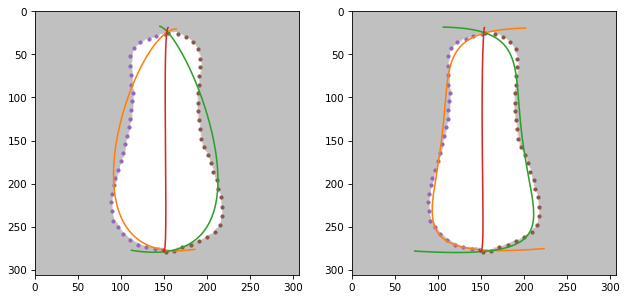

In [8]:
try34(0)

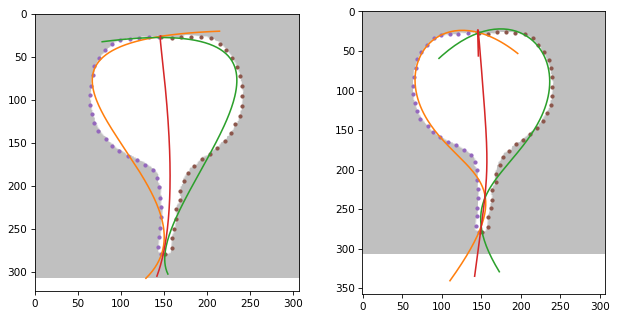

In [9]:
try34(1)

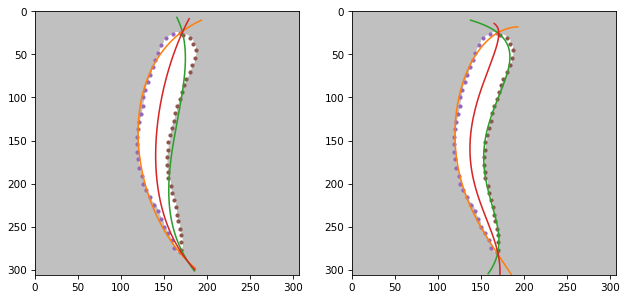

In [10]:
try34(2)

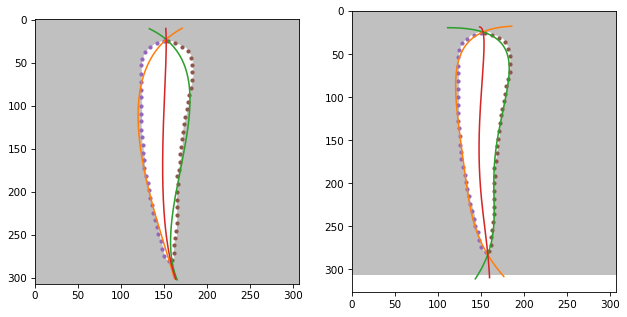

In [11]:
try34(3)

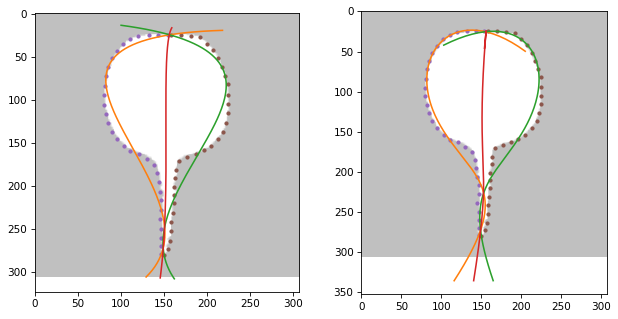

In [12]:
try34(4)

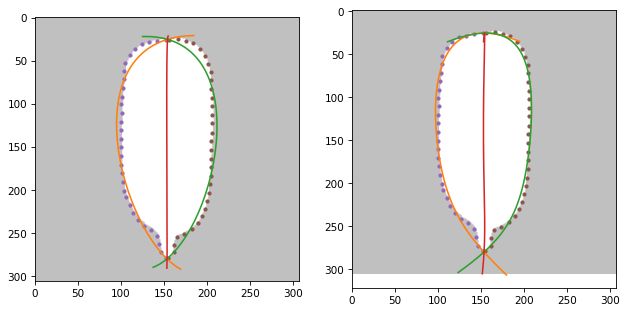

In [13]:
try34(5)

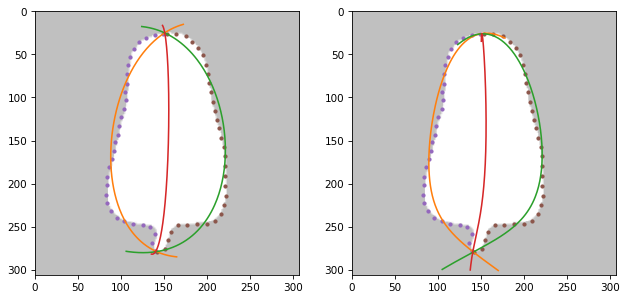

In [14]:
try34(6)

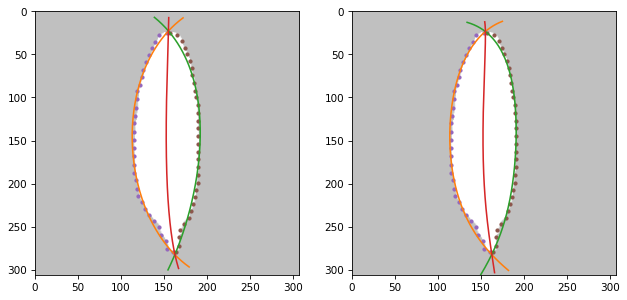

In [15]:
try34(7)

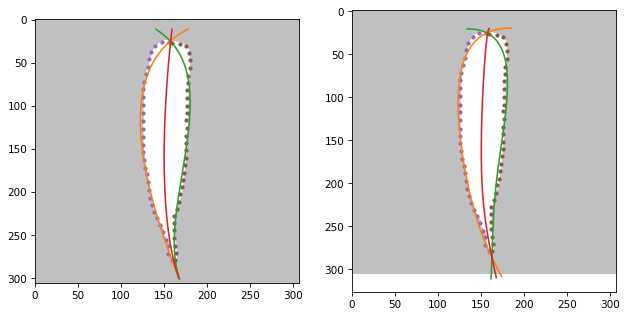

In [16]:
try34(8)

ほとんどの個体の中心軸の形状は３次近似で充分捉えられるのだが、３次と４次とでどちらが正確に形状をトレースできているかと問われると、４次に軍配を上げざるをえない。長さの計測という観点ならば、両者にそれほど差はなさそうな気はする。

# 中心軸の再近似

ここまでの実験結果を見た限りにおいては、中心線の形状記述として、４次の高速当てはめから求めた曲線も、６次以上の厳密当てはめから求めた曲線も大きな違いはなさそうである。

ただ、４次以上だと上端部分で傾きが不自然（接線が上下ではなく水平方向寄りになる）であるし、高次の近似を用いた場合は左右の形状のいびつさに影響されて合成で求めた関数まで不自然な変動が生じるので、関数式をもとにして標本点を生成した上で再近似をこころみる。

### 中心軸上の点のサンプリング

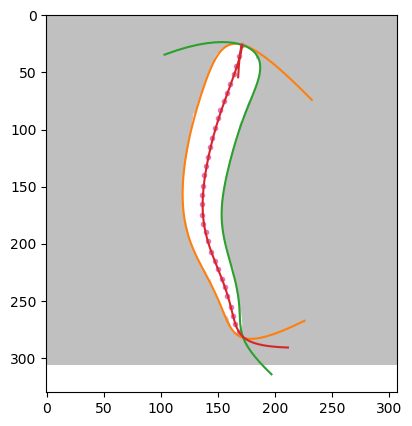

In [17]:
num = 2
img = imgs[num]
fl = fLlist[num]
fr = fRlist[num]
fc = (fl+fr)/2
dp = rd.getDenseParameters(fc,n_samples=32,span=0) #  均等間隔になるようなパラメータセットを求める
samples = [[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp]
samples = np.array(samples)
rd.drawBez(img,stt=-0.1,end=1.1,bezL=fl,bezR=fr,bezC=fc,cntC = samples,figsize=(5,5),dpi=100,ct=list("12345678"))

In [18]:
def reSampleAndFit(num,n_samples=32):
    img = imgs[num]
    fl = fLlist[num] # 左の近似曲線
    fr = fRlist[num] # 右の近似曲線
    fc = (fl+fr)/2 # 中心線の仮近似
    dp = rd.getDenseParameters(fc,n_samples=n_samples,span=0) #  均等間隔になるようなパラメータセットを求める
    samples = [[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in dp]
    samples = np.array(samples)
    # ベジエ曲線の準備
    # rd.BezierCurve.openmode = True
    bezC = rd.BezierCurve(N=4,samples = samples,prefunc=fc) # ,prefunc=fc は使わなくてもあまり変わらない
    # ４次近似を実行
    cps,newfc = bezC.fit0()
    # 結果の描画
    plt.figure(figsize=(10,5),dpi=100)
    plt.subplot(131)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezC=fc,ct=list("02045678"))
    plt.subplot(132)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezL=fc,bezC=newfc,ct=list("02345678"))
    plt.subplot(133)
    rd.drawBez0(img,stt=-0.1,end=1.1,bezC=newfc,ct=list("02345678"))
    return newfc

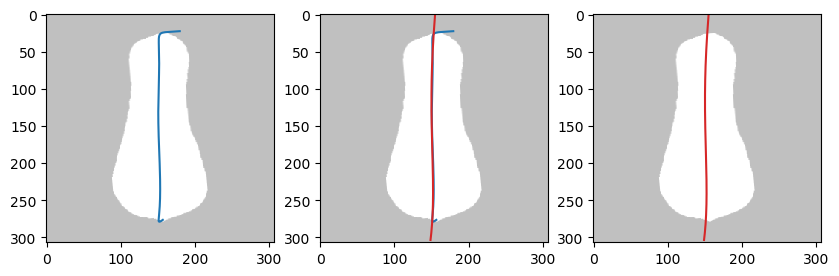

In [19]:
newFC = []
newFC.append(reSampleAndFit(0))

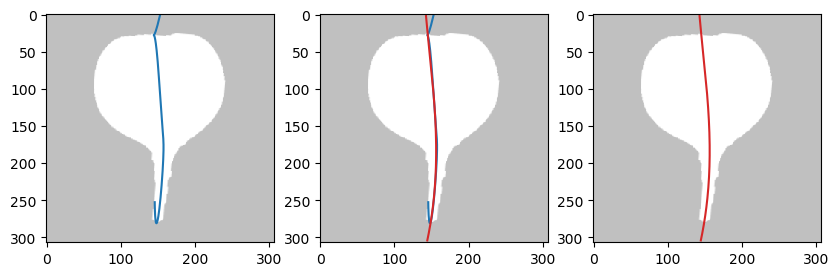

In [20]:
newFC.append(reSampleAndFit(1))

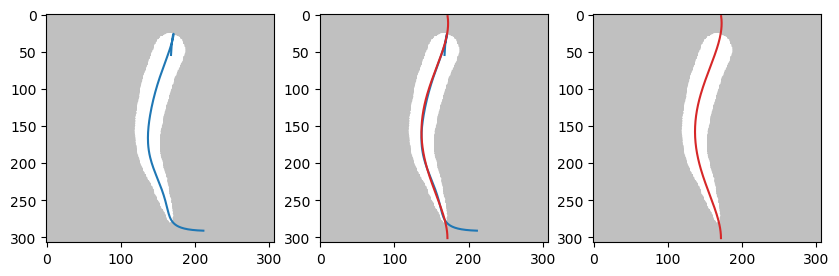

In [21]:
newFC.append(reSampleAndFit(2))

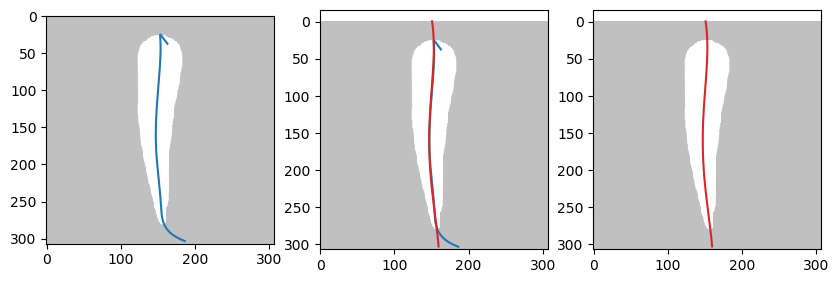

In [22]:
newFC.append(reSampleAndFit(3))

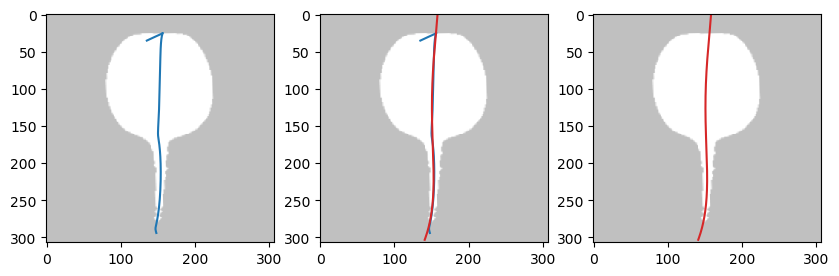

In [23]:
newFC.append(reSampleAndFit(4))

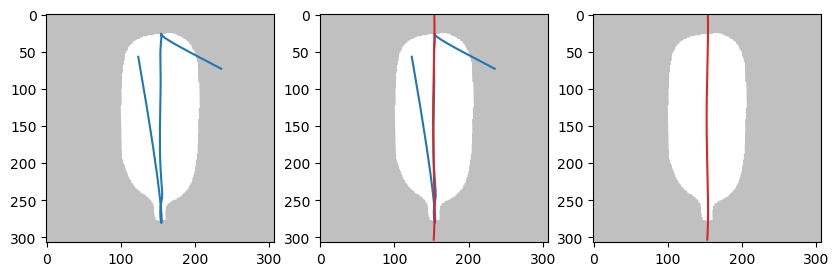

In [24]:
newFC.append(reSampleAndFit(5))

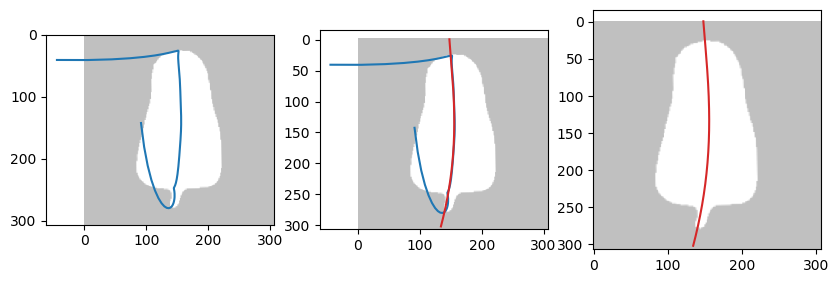

In [25]:
newFC.append(reSampleAndFit(6))

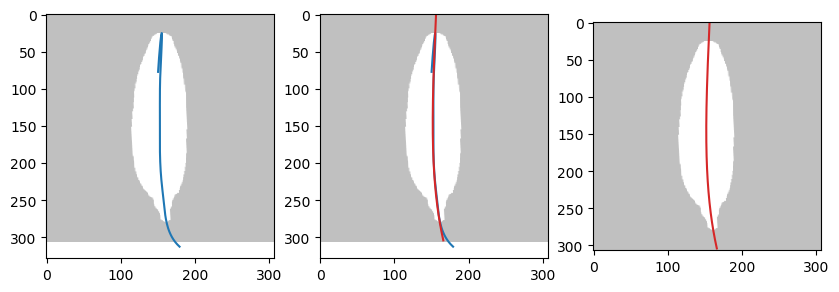

In [26]:
newFC.append(reSampleAndFit(7))

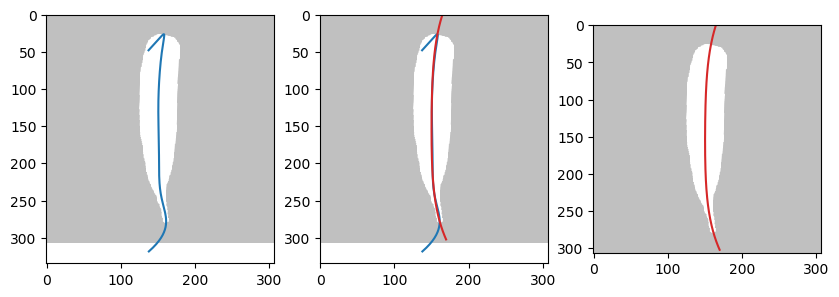

In [27]:
newFC.append(reSampleAndFit(8))

いずれも青線が左右の曲線の平均曲線であり、右が再サンプリングして得られた４次のベジエ曲線である。

なお、再サンプリングのサンプル数は３２、近似には fit0() を用いた。

これらの結果を見る限り結果は良好である。


In [65]:
# 結果の保存
if COLABORATORY:
    rd.storePkl(newFC,COLABRDROOT+'/res/newFC.pkl')
else:
    rd.storePkl(newFC,LOCALHOME+'/res/newFC.pkl')